In [183]:
# %load std_libraries.py
#to keep my scripts consistent, I am adding this to the top of all scripts with %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = other")
location_dict = {'a': "C:\\Users\\BMH_work\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",
                 'c': "C:\\Users\\Ben\\Documents\\GitHub\\expression_broad_data", 'd':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colormap as cm
#from matplotlib_venn import venn2
#for my windows10 laptop I had to install this package using pip rather than anaconda.  
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
#import statsmodels.api as sm
#import scipy.spatial.distance as spd
#import statsmodels.graphics.gofplots as stats_graph
#import scipy.cluster.hierarchy as sch

from Bio import SeqIO
#from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq
#import gffutils

import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No ")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# # for phylogenetic trees: 
# from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node  #the last three are for visualization
# # In order to view ete3 created trees on the gpucluster, you need to use a virtual X server:
# from pyvirtualdisplay import Display
# display = Display(visible=False, size=(1024, 768), color_depth=24)
# display.start()
#ete3 is not officially supported on windows, and so must be loaded via pip: 
# pip install -U https://github.com/etetoolkit/ete/archive/qt5.zip
# ref: https://groups.google.com/forum/#!topic/etetoolkit/6NblSBPij4o

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

spec_lookup = {'Klac' : 'Kluyveromyces lactis', 'Scer': 'Saccharomyces cerevisiae', 
 'Cgla' : 'Candida glabrata' , 'Ncas': 'Naumovozyma castellii', 
 'Sbay' : 'Saccharomyces bayanus', 'Smik': 'Saccharomyces mikatae',
 'Lwal' : 'Lachancea waltii', 'Spar' : 'Saccharomyces paradoxus', 
 'Lklu' : 'Lachancea kluyverii', 'Dhan': 'Debaryomyces hansenii', 
 'Calb' : 'Candida albicans', 'Ylip': 'Yarrowia lipolytica'}

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
base directory is /home/heineike/github/expression_broad_data
I am about to import a library
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
are you online? Yes/No Yes


In [134]:
#Load GOI ohnolog data
fname = data_processing_dir + os.sep + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20181205.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)


#KL orthologs
#Load KL ortholog data
kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")

#Merge k.lac rlog data with ohnolog_gois
ohnologs_goi_klorth = ohnologs_goi.merge(kl_orthologs, how='left', left_on='sc_genename_low',right_on='sc_genename')


#add high_low to be new index and sort by order from expression conservation plot: 
#Load expression_data_df_sorted in order to get correct order of genes

expression_data_df_sorted = pd.read_csv(os.path.normpath(data_processing_dir + 'regev_data/20190117_expression_data_sorted.csv'),index_col=0)
ohnologs_goi_klorth['SC_common_name_high_low']=ohnologs_goi_klorth['SC_common_name_high'] + '_' + ohnologs_goi_klorth['SC_common_name_low']

##Here I am sorting by expression_data_df_sorted -I throw out genes that aren't in my ohnolog set.  
new_index = []
for high_low in expression_data_df_sorted.index: 
    if high_low in set(ohnologs_goi_klorth['SC_common_name_high_low']):
        new_index.append(high_low)
    else:
        print(high_low + ' not in ohnologs set')

ohnologs_goi_klorth.set_index('SC_common_name_high_low', inplace=True)

ohnologs_goi_rowsort = ohnologs_goi_klorth.loc[new_index,:]

In [213]:
#Enrichment in KL and SC genes activated by PKA inhibition

output_format = 'count'
motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'}   
sequence_context = 2

prom_set_prefix = {'Klac':'kl', 'Scer':'sc'}

#Get counts for various sets
prom_counts = {}
for spec in ['Klac', 'Scer']:
    prom_counts_spec = {}
    for prom_set in ['all_' + prom_set_prefix[spec] + '_promoters',  prom_set_prefix[spec] + "_pkainh_act_20181214" ]:
        promoters_fname = data_processing_dir + os.path.normpath(prom_set_prefix[spec] + "_promoters/promoter_sets/" + prom_set + ".fasta")
        prom_counts_spec[prom_set] = io_library.exact_promoter_scan_from_fasta(promoters_fname, motif_dict, output_format = output_format, sequence_context = sequence_context)
    prom_counts[spec] = prom_counts_spec

for level in ['low', 'high']: 
    promoters_fname = data_processing_dir + os.path.normpath('sc_promoters/promoter_sets/sc_ohnologs_goi_' + level + '_20181218.fasta')
    prom_counts_spec_level = io_library.exact_promoter_scan_from_fasta(promoters_fname, motif_dict, output_format = output_format, sequence_context = sequence_context)
    prom_counts['Scer']['ohnolog_goi_' + level] = prom_counts_spec_level.rename(columns = {motif_name + '_count' : 'Scer_' + motif_name + '_count' for motif_name in motif_dict.keys()})

promoters_fname = data_processing_dir + os.path.normpath('kl_promoters/promoter_sets/kl_ohnologs_goi_20181218.fasta')
prom_counts_spec = io_library.exact_promoter_scan_from_fasta(promoters_fname, motif_dict, output_format = output_format, sequence_context = sequence_context)
prom_counts['Klac']['ohnolog_goi'] = prom_counts_spec.rename(columns = {motif_name + '_count' : 'Klac_' + motif_name + '_count' for motif_name in motif_dict.keys()})



#Add sc common name column for prom counts

##not sure why this is necessary and if it is necessary, why I only do it for high
prom_counts['Scer']['ohnolog_goi_high']['SC_common_name']=io_library.SC_common_name_lookup(prom_counts['Scer']['ohnolog_goi_high'].index)


#Do Fisher's exact test on a set of comparisons

comparisons = {'Scer' : {'goi_high_v_all': ('ohnolog_goi_high', 'all_sc_promoters'), 
                       'goi_low_v_all': ('ohnolog_goi_low', 'all_sc_promoters'), 
                       'goi_high_v_goi_low': ('ohnolog_goi_high', 'ohnolog_goi_low'), 
                       
                      }, 
               'Klac' : {'goi_kl_orth_v_all': ('ohnolog_goi','all_kl_promoters')
                      }
              }

output = {'Motif': list(motif_dict.keys())}

#Added afterwards to conform to all other species data structure
motif_calcs = {'Post WGH low':{'Scer':{'all':{}, 'goi':{}}},
               'Post WGH high': {'Scer':{'all':{}, 'goi':{}}},
               'Pre WGH': {'Klac':{'all':{}, 'goi':{}}}
              }
motif_calcs_comparison_map = {'goi_low_v_all':'Post WGH low', 
                             'goi_high_v_all':'Post WGH high', 
                             'goi_kl_orth_v_all': 'Pre WGH'}


for spec in ['Scer', 'Klac']: 
    print(spec)
    for comparison_name, comparison in comparisons[spec].items(): 
        print(comparison_name)
        pct_hits_motif = []
        pct_total_motif = []
        pvals_motif = []
        for motif_name in motif_dict.keys():
            #The first comparison is never a total so no need to look for that
            N1_hits = sum(prom_counts[spec][comparison[0]][spec + '_' + motif_name + '_count']>0)
            N1_total = len(prom_counts[spec][comparison[0]])

            print('N ' + motif_name + ' in promoters of ' + comparison[0] + ' : ' + str(N1_hits))
            print('N total promoters for ' + comparison[0] + ' : ' + str(N1_total))
            
            pct_hits_motif.append(N1_hits/N1_total)
            
            
            #The second comparison set might be a total
            if comparison_name.split('_v_')[1]=='all': 
                N_all_hits = sum(prom_counts[spec][comparison[1]][motif_name + '_count']>0)
                N_all_total = len(prom_counts[spec][comparison[1]])
                N2_hits = N_all_hits-N1_hits
                N2_total = N_all_total - N1_total
                print('N ' + motif_name + ' in promoters of ' + comparison[1] + ' : ' + str(N_all_hits))
                print('N total promoters for ' + comparison[1] + ' : ' + str(N_all_total))
                
                pct_total_motif.append(N_all_hits/N_all_total)
                
            else: 
                N2_hits = sum(prom_counts[spec][comparison[1]][spec + '_' + motif_name + '_count']>0)
                N2_total = len(prom_counts[spec][comparison[1]])

                print('N ' + motif_name + ' in promoters of ' + comparison[1] + ' : ' + str(N2_hits))
                print('N total promoters for ' + comparison[1] + ' : ' + str(N2_total))  
                
                pct_total_motif.append(N2_hits/N2_total)
    
            oddsratio, pvalue = stats.fisher_exact([[N1_hits, N2_hits],
                                                [N1_total, N2_total]], 
                                                  alternative = 'two-sided')
            
            #add pvalue to output
            pvals_motif.append(pvalue)
            
            if comparison_name in {'goi_kl_orth_v_all', 'goi_high_v_all', 'goi_low_v_all'}:
                spec_set_name = motif_calcs_comparison_map[comparison_name]
                #totals get written over each time, but that shouldn't be a problem
                motif_calcs[spec_set_name][spec]['all']['total'] =  N_all_total
                motif_calcs[spec_set_name][spec]['all'][motif_name] = {'hits': N_all_hits, 'pct': N_all_hits/N_all_total}
                motif_calcs[spec_set_name][spec]['goi']['total'] = N1_total
                motif_calcs[spec_set_name][spec]['goi'][motif_name] = {'hits': N1_hits, 'pct': N1_hits/N1_total, 'pval': pvalue}

                
        output[comparison_name + '_pct_hits'] = pct_hits_motif
        output[comparison_name + '_pct_total'] = pct_total_motif
        output[comparison_name + '_pval'] = pvals_motif


output_df = pd.DataFrame.from_dict(output, orient='columns') #index = motif_dict.keys())
output_df.set_index('Motif', inplace=True)

output_fname = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/STRE_TATA_PDS_enrichment_20181218.csv")

output_df.to_csv(output_fname)

Scer
goi_high_v_goi_low
N STRE in promoters of ohnolog_goi_high : 77
N total promoters for ohnolog_goi_high : 91
N STRE in promoters of ohnolog_goi_low : 45
N total promoters for ohnolog_goi_low : 91
N TATA in promoters of ohnolog_goi_high : 66
N total promoters for ohnolog_goi_high : 91
N TATA in promoters of ohnolog_goi_low : 62
N total promoters for ohnolog_goi_low : 91
N PDS in promoters of ohnolog_goi_high : 30
N total promoters for ohnolog_goi_high : 91
N PDS in promoters of ohnolog_goi_low : 17
N total promoters for ohnolog_goi_low : 91
goi_low_v_all
N STRE in promoters of ohnolog_goi_low : 45
N total promoters for ohnolog_goi_low : 91
N STRE in promoters of all_sc_promoters : 2928
N total promoters for all_sc_promoters : 6674
N TATA in promoters of ohnolog_goi_low : 62
N total promoters for ohnolog_goi_low : 91
N TATA in promoters of all_sc_promoters : 3852
N total promoters for all_sc_promoters : 6674
N PDS in promoters of ohnolog_goi_low : 17
N total promoters for ohnolog_goi

In [209]:
motif_calcs

{'Post WGH high': {'Scer': {'all': {'PDS': {'hits': 1403,
     'pct': 0.21021875936469883},
    'STRE': {'hits': 2928, 'pct': 0.43871741084806715},
    'TATA': {'hits': 3852, 'pct': 0.5771651183697932},
    'total': 6674},
   'goi': {'PDS': {'hits': 30,
     'pct': 0.32967032967032966,
     'pval': 0.038871377130740667},
    'STRE': {'hits': 77,
     'pct': 0.8461538461538461,
     'pval': 2.9081743310339195e-05},
    'TATA': {'hits': 66,
     'pct': 0.7252747252747253,
     'pval': 0.15659284314265859},
    'total': 91}}},
 'Post WGH low': {'Scer': {'all': {'PDS': {'hits': 1403,
     'pct': 0.21021875936469883},
    'STRE': {'hits': 2928, 'pct': 0.43871741084806715},
    'TATA': {'hits': 3852, 'pct': 0.5771651183697932},
    'total': 6674},
   'goi': {'PDS': {'hits': 17,
     'pct': 0.18681318681318682,
     'pval': 0.7979074855977788},
    'STRE': {'hits': 45,
     'pct': 0.4945054945054945,
     'pval': 0.51211942832859403},
    'TATA': {'hits': 62,
     'pct': 0.6813186813186813,
 

In [214]:
#Get promoter counts for S.Cer and K.Lac

#merge in promoter counts
ohnologs_goi_prom_counts = ohnologs_goi_rowsort.merge(prom_counts['Scer']['ohnolog_goi_high'], how='left', left_on='sc_genename_high', right_index=True)
ohnologs_goi_prom_counts = ohnologs_goi_prom_counts.merge(prom_counts['Scer']['ohnolog_goi_low'], how = 'left', left_on = 'sc_genename_low', right_index=True, suffixes=('_high','_low'))

#merge in KL promoter counts
prom_counts_kl = prom_counts['Klac']['ohnolog_goi'].copy()
#prom_counts_kl.rename(columns={column:column + '_kl' for column in prom_counts_kl.columns}, inplace=True)

ohnologs_goi_prom_counts = ohnologs_goi_prom_counts.merge(prom_counts_kl, how = 'left', left_on = 'kl_genename', right_index=True)



In [87]:
# Only need to do once

# #Using YGOB Genomes
# specs = ['Smik','Suva','Cgla', 'Vpol','Lwal','Lklu']    #'Ncas'
# L_prom = 700

# #This should be a function
# for spec in specs: 
#     promoter_dir = data_processing_dir + os.path.normpath('promoter_phylogeny/promoter_sets/' + spec)
# #     if spec != 'Smik':
# #         os.mkdir(promoter_dir)
#     io_library.ygob_promoter_extract(spec, L_prom)


promoter region extends past the scaffold, spec = SmikGene = Smik_10.446, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_12.568, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_14.412, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_17.27, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_18.19, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_18.20, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_19.14, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_30.trna6, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_31.2, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_31.3, L_prom = 700
promoter region extends past the scaffold, spec = SmikGene = Smik_42.2, L_prom = 700
promoter region extends past the scaffold, spec = S

promoter region extends past the scaffold, spec = VpolGene = Kpol_473.23, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_303.7, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_461.23, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_365.13, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_177.2, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_1001.31, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_389.1, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_354.10, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_460.25, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_286.5, L_prom = 700
promoter region extends past the scaffold, spec = VpolGene = Kpol_344.10, L_prom = 700
promoter region extends past the scaffold, spe

promoter region extends past the scaffold, spec = LkluGene = SAKL0C14080g, L_prom = 700
promoter region extends past the scaffold, spec = LkluGene = SAKL0D15422g, L_prom = 700
All promoters for Lklu saved in /home/heineike/github/expression_broad_data/expression_data/promoter_phylogeny/promoter_sets/Lklu/all_promoters_700.fasta
short promoters saved in /home/heineike/github/expression_broad_data/expression_data/promoter_phylogeny/promoter_sets/Lklu/short_promoters.fasta


In [88]:
#Only need to do once

# specs = ['Smik','Suva','Cgla', 'Vpol','Lwal','Lklu']    #'Ncas'

# for spec in specs: 
#     io_library.write_YGOB_orth_lookup_table('Scer', spec)


/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Smik-orthologs.txt
/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Suva-orthologs.txt
/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Cgla-orthologs.txt
/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Vpol-orthologs.txt
/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Lwal-orthologs.txt
/home/heineike/github/expression_broad_data/expression_data/ortholog_files_YGOB/Scer-Lklu-orthologs.txt


In [215]:
#For GOI list in S.Cer, get enrichment of STRE's for a set of species.  

ohnologs_goi = ohnologs_goi_prom_counts

L_prom = 700
output_format = 'full'
motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'} 
sequence_context = 2   

spec_order_post_WGH = ['Smik','Suva', 'Cgla', 'Ncas','Vpol']  #should add S.Cer, maybe S.Par but that would take a bit of work
spec_order_pre_WGH = ['Lwal','Lklu']  #Should add K.Lac.  others not in YGOB - might be able to get Calb promoters fairly easily

spec_sets = {'Post WGH low' : spec_order_post_WGH, 
             'Post WGH high' : spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}

#motif_calcs = {}  #already set up in S.Cer/K.Lac routine above
for spec_set_name, spec_set in spec_sets.items(): 
    level = levels[spec_set_name]
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'
    #motif_calcs[spec_set_name] = {}  #already set up in S.Cer/K.Lac routine above
    for spec in spec_set:
        print(spec)
        promoter_dir = data_processing_dir + os.path.normpath('promoter_phylogeny/promoter_sets/' + spec)
        all_promoters_fname = os.path.normpath(promoter_dir + '/all_promoters_' + str(L_prom) + '.fasta')
        all_promoters = SeqIO.to_dict(SeqIO.parse(all_promoters_fname, "fasta"))  

        #scan all promoters for motifs
        all_promoters_scan = io_library.exact_promoter_scan_from_fasta(all_promoters_fname, 
                                                  motif_dict, 
                                                  output_format = 'full', 
                                                  sequence_context = 2, 
                                                  L_prom = None)
        motif_calcs_spec = {}
        motif_calcs_spec['all'] = {'total':len(all_promoters_scan)}
        for motif_name in motif_dict.keys():
            motif_calcs_spec['all'][motif_name]={'hits': sum(all_promoters_scan[motif_name + '_count']>0)}
            motif_calcs_spec['all'][motif_name]['pct'] = (motif_calcs_spec['all'][motif_name]['hits'])/(motif_calcs_spec['all']['total'])

        #     print('N ' + motif_name + ' in promoters of ' + spec + ' : ' + str(N_all_hits))
        #     print('N total promoters for ' + spec + ' : ' + str(N_all_total))


        #Get goi orthologs for this species
        #load ortholog mapping
        orth_lookup = io_library.read_orth_lookup_table('Scer', spec, data_processing_dir + os.sep + "ortholog_files_YGOB" + os.sep)


        #for each level, scan for motifs and add a column to the ohnologs_goi dataset.  Also outputs
        #promoter set file fora given set
        #also outputs enrichment calculations


        genes = []
        
        if spec_set_name == 'Pre WGH' :
            #for pre_wgh species checks to see if ortholog matches
            for row in ohnologs_goi.loc[:,['sc_genename_low','sc_genename_high']].iterrows(): 
                orth_low = orth_lookup[row[1].sc_genename_low][0]
                orth_high = orth_lookup[row[1].sc_genename_high][0]
                if ((len(orth_lookup[row[1].sc_genename_low])==2)|(len(orth_lookup[row[1].sc_genename_low])==2)):
                    raise ValueError('more than one ortholog for a given sc_gene :' + row[1].sc_genename_low + ' -> ' + orth_lookup[row[1].sc_genename_low] +
                                     ', ' + row[1].sc_genename_high + ' -> ' + orth_lookup[row[1].sc_genename_low])
                if orth_low != orth_high:
                    raise ValueError('Orthologs of WGH paralogs do not match : ' + row[1].sc_genename_low + ' -> ' + orth_low +
                                     ', ' + row[1].sc_genename_high + ' -> ' + orth_high) # + '. Used high ortholog')
                    #genes.append(orth_high)
                else:
                    genes.append(orth_high)
        else: 
            for sc_gene in ohnologs_goi['sc_genename' + level_sep + level]:
                gene = orth_lookup[sc_gene]
                if len(gene)==2:
                    print(gene + ' has more than one ortholog for ' + sc_gene)
                genes.append(gene[0])
        
        ohnologs_goi[spec + '_genename' + level_sep + level] = genes
        
        goi_promoters_fname = promoter_dir + os.sep + 'depka' + level_sep + level + '_' + str(L_prom) + '.fasta'
        
        seqs = []
        motif_scan_results = {motif_name:[] for motif_name in motif_dict.keys()}
        motif_scan_counts = {motif_name:[] for motif_name in motif_dict.keys()}
        for gene in genes:
            if gene != 'NONE':
                try: 
                    seq = all_promoters[gene]
                    seqs.append(seq)
                    for motif_name, motif in motif_dict.items():
                        motif_scan_result = io_library.exact_promoter_scan(motif, seq, output_format=output_format, sequence_context=2)
                        motif_scan_results[motif_name].append(motif_scan_result)
                        motif_scan_counts[motif_name].append(len(motif_scan_result))
                except KeyError:
                    print(gene + ' not present in promoter dict for ' + spec)
                    for motif_name, motif in motif_dict.items():
                        motif_scan_results[motif_name].append('NONE')
                        motif_scan_counts[motif_name].append(np.nan)
            else:
                for motif_name, motif in motif_dict.items():
                    motif_scan_results[motif_name].append('NONE')
                    motif_scan_counts[motif_name].append(np.nan)
        
        with open(goi_promoters_fname, 'w') as f: 
            SeqIO.write(seqs, f, 'fasta')

        
        #Add column to dataframe and make enrichment calculations. 
        orthologs_present = [gene for gene in genes if gene!='NONE']
        motif_calcs_spec['goi'] = {'total': len(orthologs_present)}
        N2_total = motif_calcs_spec['all']['total'] - motif_calcs_spec['goi']['total']
        for motif_name in motif_dict.keys(): 
            ohnologs_goi[spec + '_' + motif_name + '_count' + level_sep + level] = motif_scan_counts[motif_name]
            ohnologs_goi[spec + '_' + motif_name + '_result'+ level_sep + level] = motif_scan_results[motif_name]
            
            motif_gt0 = [n_motif for n_motif in motif_scan_counts[motif_name] if ((not(np.isnan(n_motif))) & (n_motif>0))]
            motif_calcs_spec['goi'][motif_name] = {'hits':len(motif_gt0)}
            motif_calcs_spec['goi'][motif_name]['pct'] = (motif_calcs_spec['goi'][motif_name]['hits'])/(motif_calcs_spec['goi']['total'])
            N2_hits = motif_calcs_spec['all'][motif_name]['hits'] - motif_calcs_spec['goi'][motif_name]['hits']

            oddsratio, pvalue = stats.fisher_exact([
                                                    [motif_calcs_spec['goi'][motif_name]['hits'], N2_hits],
                                                    [motif_calcs_spec['goi']['total'], N2_total]
                                                   ], 
                                                   alternative = 'two-sided')        
            motif_calcs_spec['goi'][motif_name]['pval'] = pvalue

        motif_calcs[spec_set_name][spec] = motif_calcs_spec

motif_calcs

Lwal
Lklu
Smik
Suva
Cgla
Ncas
Vpol
Smik
Suva
Cgla
Ncas
Vpol
Kpol_260.5 not present in promoter dict for Vpol
Kpol_282.1 not present in promoter dict for Vpol


{'Post WGH high': {'Cgla': {'all': {'PDS': {'hits': 1206,
     'pct': 0.220838674235488},
    'STRE': {'hits': 2106, 'pct': 0.38564365500824027},
    'TATA': {'hits': 3424, 'pct': 0.6269913935176707},
    'total': 5461},
   'goi': {'PDS': {'hits': 21,
     'pct': 0.2876712328767123,
     'pval': 0.2806765514014784},
    'STRE': {'hits': 48,
     'pct': 0.6575342465753424,
     'pval': 0.0054769632705036174},
    'TATA': {'hits': 48,
     'pct': 0.6575342465753424,
     'pval': 0.85089116543902088},
    'total': 73}},
  'Ncas': {'all': {'PDS': {'hits': 1406, 'pct': 0.2372595342558218},
    'STRE': {'hits': 2721, 'pct': 0.45916301046236924},
    'TATA': {'hits': 3305, 'pct': 0.5577117786027674},
    'total': 5926},
   'goi': {'PDS': {'hits': 19,
     'pct': 0.2638888888888889,
     'pval': 0.68760815564671862},
    'STRE': {'hits': 41,
     'pct': 0.5694444444444444,
     'pval': 0.2637573924790787},
    'TATA': {'hits': 49,
     'pct': 0.6805555555555556,
     'pval': 0.2941153813503654

<IPython.core.display.Javascript object>


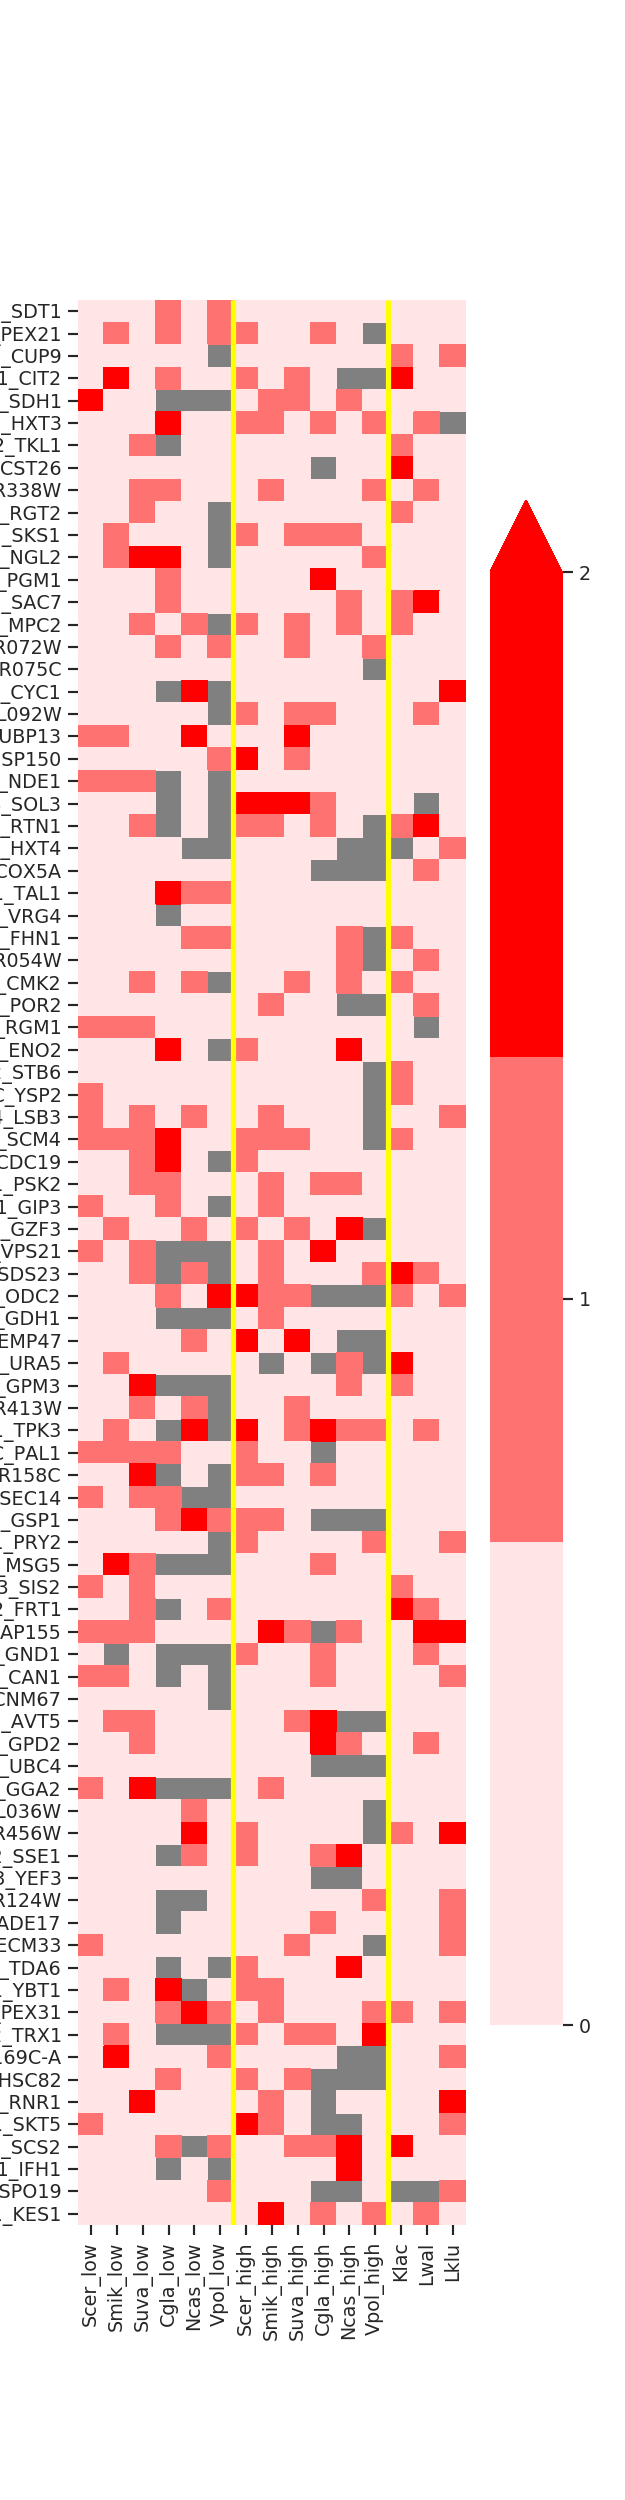

In [198]:
# Plot heatmap of all STREs in same order 
# heatmap after filtering and sorting

motif = 'PDS'

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : ['Klac'] + spec_order_pre_WGH} 

levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}


columns_to_show = []
label_order = []
for spec_set_name in ['Post WGH low', 'Post WGH high', 'Pre WGH']: 
    spec_set = spec_sets[spec_set_name]
    level = levels[spec_set_name]
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'
        
    for spec in spec_set: 
        
        columns_to_show.append(spec + '_' + motif + '_count' + level_sep + level)
        label_order.append(spec + level_sep + level)
        
        
#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
  
big_lines = []
for jj,label in enumerate(label_order):
    if label in {'Vpol_low', 'Vpol_high'}:
        big_lines.append(jj+1)

        
        
ohnologs_goi_counts = ohnologs_goi.loc[:, columns_to_show]

fig_STRE, ax_STRE = plt.subplots(figsize=(5,20))

#cmap = cm.get_cmap('PiYG', 11) 
sns.heatmap(ohnologs_goi_counts, vmax = 2, ax=ax_STRE, cmap=sns.light_palette("red",3), cbar_kws={'ticks':[0,1,2], 'extend': 'max'}) #, 'yticklabels':['0', '1', '>1']})

ax_STRE.set_facecolor("grey")
ax_STRE.set_xticklabels(label_order)
ax_STRE.vlines(big_lines, ymin = 0, ymax = len(ohnologs_goi_counts), colors = 'yellow',linewidth=3)

fig_STRE.savefig(os.path.normpath('/home/heineike/scratch/' + motif + '_evol_DEPKA_20190129.svg'),bbox_inches='tight')





<IPython.core.display.Javascript object>


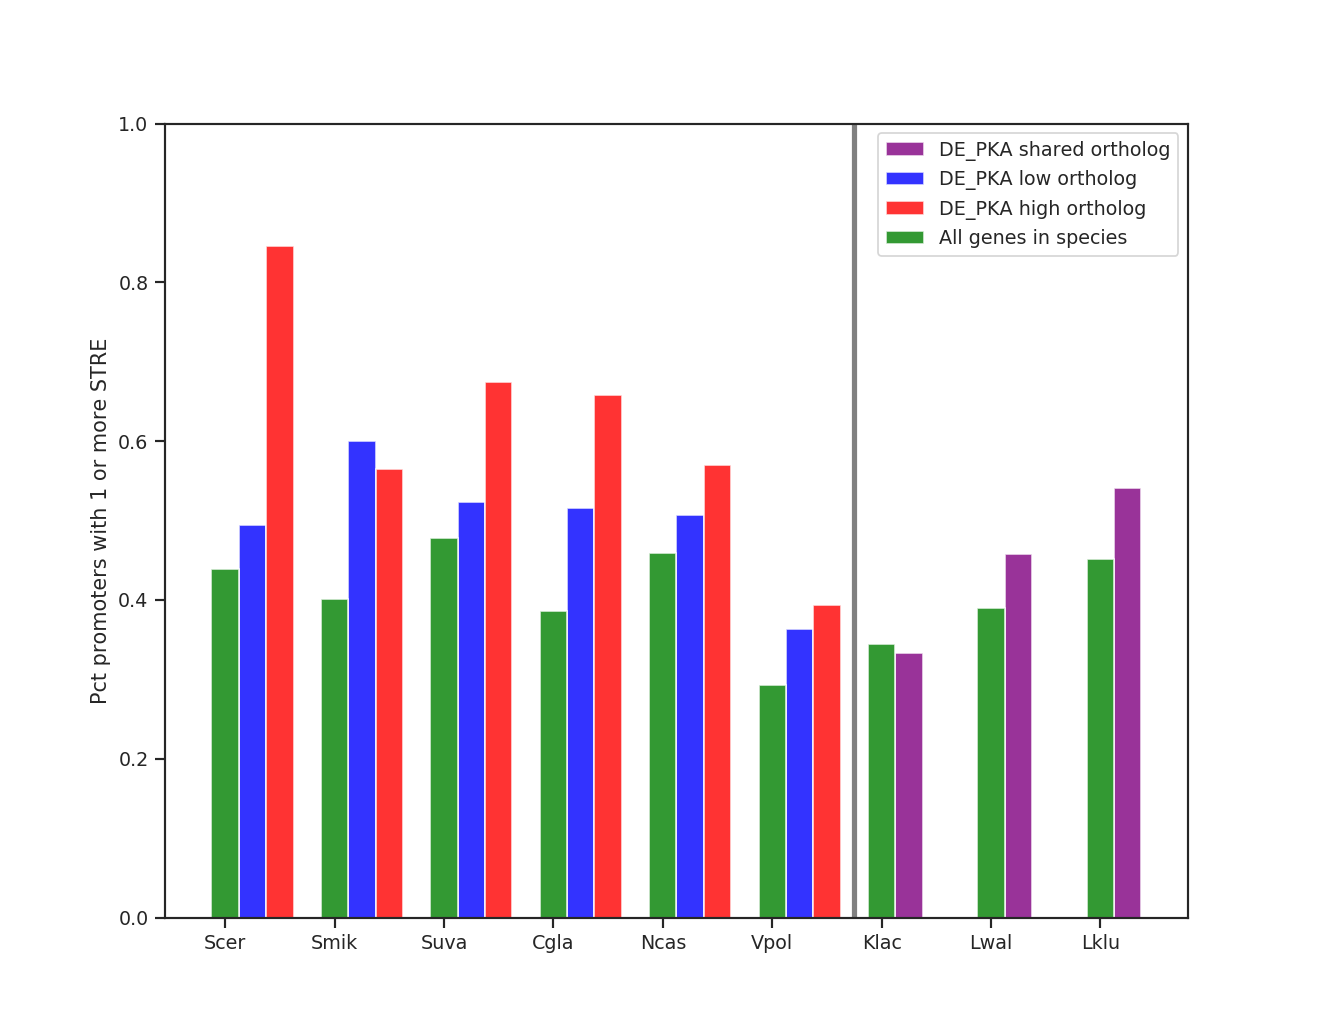

In [232]:
#Plot percentage of STREs in low and high as you go away from S.Cer

motif_name = 'STRE'

fig_pct, ax_pct = plt.subplots()
bw = 0.25
opacity = 0.8

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : ['Klac'] + spec_order_pre_WGH} 

colors = {'all':'green', 'low': 'blue', 'high':'red', 'Pre WGH': 'purple'}
legend_labels = {'all':'All genes in species', 'low': 'DE_PKA low ortholog', 
                 'high':'DE_PKA high ortholog', 'Pre WGH': 'DE_PKA shared ortholog'}
index = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
data = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
label_order = []
jj = 0

#Post WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Post WGH high']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['low'].append(jj+bw)
    index['high'].append(jj+bw*2)
    data['all'].append(motif_calcs['Post WGH high'][spec]['all'][motif_name]['pct'])
    data['low'].append(motif_calcs['Post WGH low'][spec]['goi'][motif_name]['pct'])
    data['high'].append(motif_calcs['Post WGH high'][spec]['goi'][motif_name]['pct'])    
    jj = jj+1

#pre WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Pre WGH']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['Pre WGH'].append(jj+bw)
    data['all'].append(motif_calcs['Pre WGH'][spec]['all'][motif_name]['pct'])
    data['Pre WGH'].append(motif_calcs['Pre WGH'][spec]['goi'][motif_name]['pct'])
    jj = jj+1

    
for subset_name, subset_data in data.items(): 
    
    pct_plot = ax_pct.bar(index[subset_name],subset_data, bw,
                 alpha=opacity,
                 color=colors[subset_name],
                 label=legend_labels[subset_name]) 
                 #bottom = bottom)

ax_pct.vlines([len(index['low'])-0.25], ymin = 0, ymax = 1.0, colors = 'gray',linewidth=3)
ax_pct.set_xticklabels(label_order)
ax_pct.set_xticks(index['all'])
ax_pct.set_ylim(0,1.0)
ax_pct.set_ylabel('Pct promoters with 1 or more STRE')
ax_pct.legend()

In [227]:
index[subset_name]

[0.25, 1.25, 2.25, 3.25, 4.25, 5.25]

In [228]:
subset_data

[0.4945054945054945,
 0.8461538461538461,
 0.6,
 0.5647058823529412,
 0.5232558139534884,
 0.6744186046511628,
 0.5161290322580645,
 0.6575342465753424,
 0.5068493150684932,
 0.5694444444444444,
 0.36363636363636365,
 0.39344262295081966]

In [ ]:
#For a given high_gene, plot expression across all conditions for all its orthologs

#Plot it in three subplots - high, low, pre_wgh

high_gene = 'FMP43'
row = ohnologs_goi_array[ohnologs_goi_array['SC_common_name_high']==high_gene]

fig, axarr = plt.subplots(3,1, figsize = (15,15))
spec_frac = 0.8  #fraction of distance between 1 and the next number a species takes up
opacity = 0.8

# spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 


levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}

for kk, spec_set_name in enumerate(spec_sets.keys()):
    
    ax = axarr[kk]
    level = levels[spec_set_name]
    spec_set = spec_sets[spec_set_name]
    
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'

    #Build dicts to store data from all possible conditions that we want to consider

    #all_conds = list(set(list(chain.from_iterable([list(conditions) for spec, conditions in spec_conditions.items()]))))

    #this puts it in a better order
    all_conds = ['LAG/LOG','LL/LOG','ELL/LOG','DS/LOG','EPS/LOG','PS/LOG','LPS/LOG','PLAT/LOG',
     'NaCl_005',
     'NaCl_015',
     'NaCl_030',
     'NaCl_060', 
     'heat shock_005',
     'heat shock_015',
     'heat shock_030',
     'heat shock_045',
     'heat shock_060',
     'hydrogen peroxide_005',
     'hydrogen peroxide_015',
     'hydrogen peroxide_030',
     'hydrogen peroxide_060']

    #Build colordict to separate conditions
    colors = {}
    for condition in all_conds: 
        if ("/" in condition):
            colors[condition] = 'green'
        elif('heat shock' in condition):
            colors[condition] = 'red'
        elif('NaCl' in condition): 
            colors[condition] = 'blue'
        elif('hydrogen peroxide' in condition): 
            colors[condition] = 'cyan'

    index = {condition : [] for condition in all_conds} 
    bar_width = {condition : [] for condition in all_conds}
    data = {condition : [] for condition in all_conds}   


    for spec_ind, spec in enumerate(spec_set): 
        #If S.Cer always only one orth.  
        if spec== 'Scer': 
            N_orth = 1
        else: 
            N_orth = row[spec + '_N' + level_sep + level].iloc[0]

        conditions = spec_conditions[spec]
        N_cond = len(conditions)

        if N_orth==0:
            dw = spec_frac/N_cond
        else: 
            dw = spec_frac/(N_cond*N_orth)

        for condition_ind, condition in enumerate(conditions): 
            #append data for each condition to the set of bars to be plotted

            if N_orth ==0:
                index[condition].append(spec_ind + dw*condition_ind)
                bar_width[condition].append(dw)
                data[condition].append(np.nan)
            else: 
                for jj in range(0,N_orth): 
                    index[condition].append(spec_ind + dw*condition_ind + jj*dw/N_cond)
                    bar_width[condition].append(dw/N_orth)
                    data[condition].append(row[spec + '_' + condition + level_sep + level].values[0][jj])


            rects_pre_WGH = ax.bar(index[condition], np.array(data[condition]), bar_width[condition],
                             alpha=opacity,
                             color=colors[condition],
                             label=condition) 
                             #bottom = bottom)

    if kk==2: 
        ax.set_xlabel('Species')
    ax.set_ylabel('Exp FC')
    ax.set_ylim(-4,8)
    ax.set_title(spec_set_name)
    ax.set_xticks(np.arange(len(spec_set))+spec_frac/2.0)
    ax.set_xticklabels(spec_set)

fig.suptitle(row['SC_common_name_low'].values[0] + ' ' +  row['SC_common_name_high'].values[0])



##  STRE enrichment with DE Stress genes - S.Cer

In [254]:
#Load GOI ohnolog data

seed_spec = 'Scer'

fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_' + seed_spec + '_PKAest_20190123.pkl')
with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

L_prom = 700
output_format = 'full'
motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'} 
sequence_context = 2   

spec_order_post_WGH = ['Scer','Smik','Suva', 'Cgla', 'Ncas','Vpol']  
spec_order_pre_WGH = ['Klac','Lwal','Lklu']  #might be able to get Calb promoters fairly easily

    
#Add SC_common_name_high, low and high_low columns to an ohnologs_file
ohnologs_goi = io_library.SC_common_name_columns_ohnologs(ohnologs_goi, seed_spec)
ohnologs_goi.reset_index(inplace=True)
ohnologs_goi.set_index('SC_common_name_high_low', inplace=True)

#Load expression_data_df_sorted in order to get correct order of genes
fname_exp_data_sorted = os.path.normpath(data_processing_dir + 'regev_data/20190130_expression_data_DE_stress_' + seed_spec +'_sorted.csv')
expression_data_df_sorted = pd.read_csv(fname_exp_data_sorted,index_col=0)

#Throw out genes that aren't in my ohnolog set.  
new_index = []
for high_low in expression_data_df_sorted.index: 
    if high_low in set(ohnologs_goi.index):
        new_index.append(high_low)
    else:
        print(high_low + ' not in ohnologs set')

#sort genes by new index: 
ohnologs_goi_rowsort = ohnologs_goi.loc[new_index,:]

ohnologs_goi = ohnologs_goi_rowsort
    
ohnologs_goi, motif_calcs = io_library.motif_scan_YGOB_specs(ohnologs_goi, seed_spec, spec_order_pre_WGH, spec_order_post_WGH, motif_dict, L_prom=L_prom,output_format=output_format, sequence_context=sequence_context )


I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
base directory is /home/heineike/github/expression_broad_data
data processing dir is /home/heineike/github/expression_broad_data/expression_data/
Klac
Lwal
Lklu
Scer
Smik
Suva
Cgla
Ncas
Vpol
Scer
Smik
Suva
Cgla
Ncas
Vpol
Kpol_218.5 not present in promoter dict for Vpol
Kpol_260.5 not present in promoter dict for Vpol
Kpol_282.1 not present in promoter dict for Vpol


I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
base directory is /home/heineike/github/expression_broad_data
data processing dir is /home/heineike/github/expression_broad_data/expression_data/


<IPython.core.display.Javascript object>


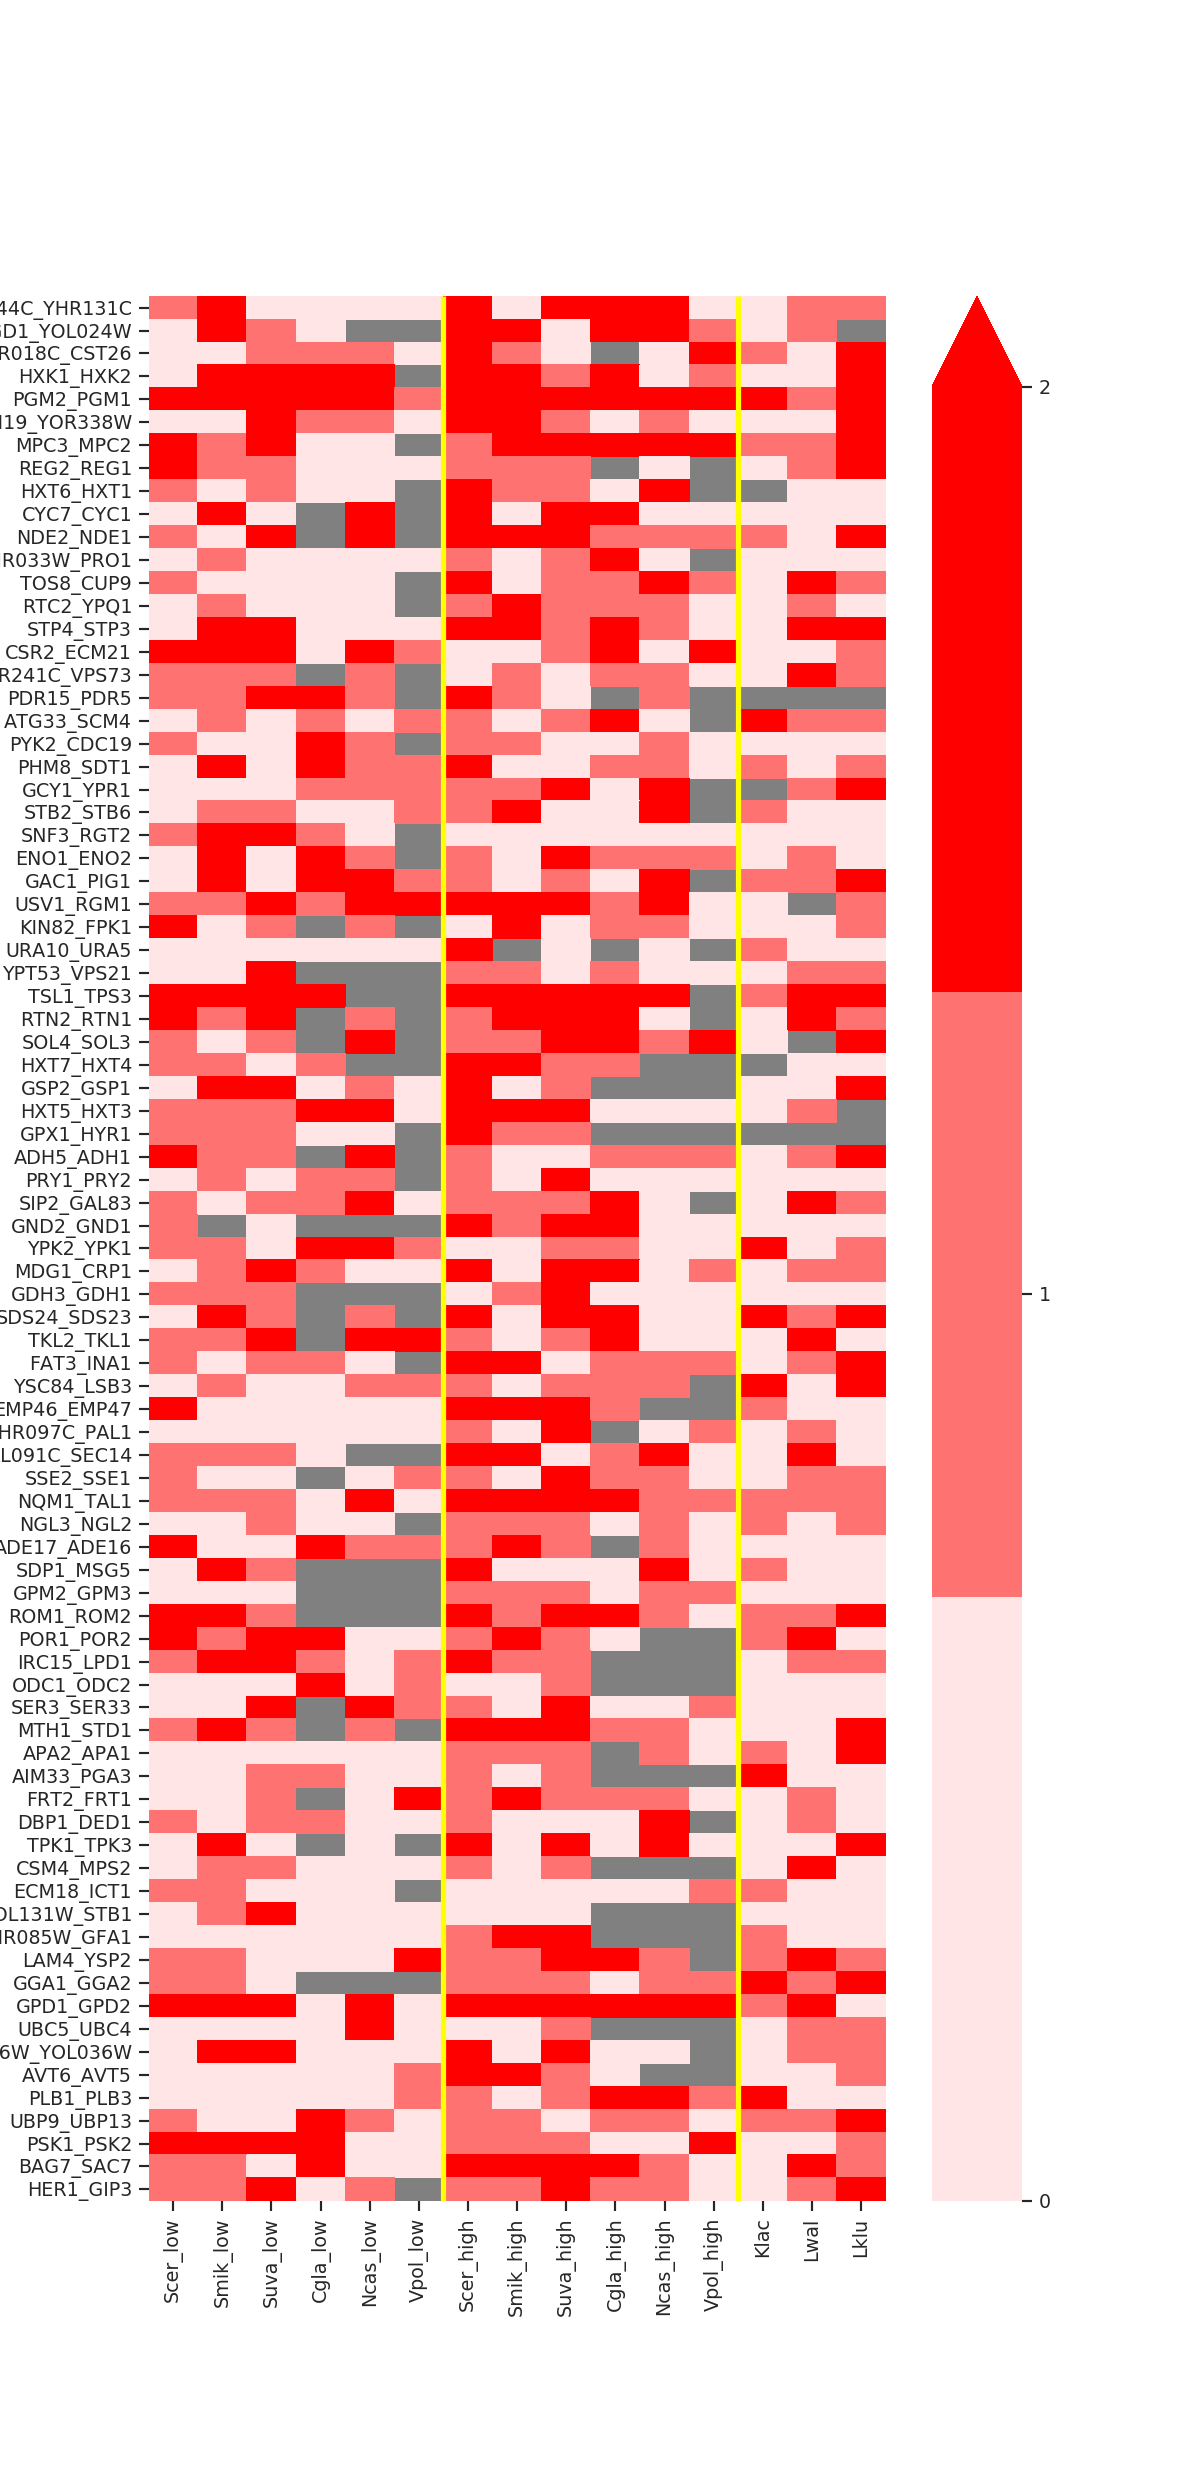

In [255]:
# Plot heatmap of all STREs in same order 
# heatmap after filtering and sorting

motif_name = 'STRE'

spec_sets = {'Post WGH low' : spec_order_post_WGH, 
             'Post WGH high' : spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}


columns_to_show = []
label_order = []
for spec_set_name in ['Post WGH low', 'Post WGH high', 'Pre WGH']: 
    spec_set = spec_sets[spec_set_name]
    level = levels[spec_set_name]
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'
        
    for spec in spec_set: 
        
        columns_to_show.append(spec + '_' + motif_name + '_count' + level_sep + level)
        label_order.append(spec + level_sep + level)
        
        
#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
  
big_lines = []
for jj,label in enumerate(label_order):
    if label in {'Vpol_low', 'Vpol_high'}:
        big_lines.append(jj+1)

        
        
ohnologs_goi_counts = ohnologs_goi.loc[:, columns_to_show]

fig_STRE, ax_STRE = plt.subplots(figsize=(5,20))

#cmap = cm.get_cmap('PiYG', 11) 
sns.heatmap(ohnologs_goi_counts, vmax = 2, ax=ax_STRE, cmap=sns.light_palette("red",3), cbar_kws={'ticks':[0,1,2], 'extend': 'max'}) #, 'yticklabels':['0', '1', '>1']})

ax_STRE.set_facecolor("grey")
ax_STRE.set_xticklabels(label_order)
ax_STRE.vlines(big_lines, ymin = 0, ymax = len(ohnologs_goi_counts), colors = 'yellow',linewidth=3)

fig_STRE.savefig(os.path.normpath('/home/heineike/scratch/' + motif_name + '_evol_DEstress' + seed_spec + '_20190130.svg'),bbox_inches='tight')




<IPython.core.display.Javascript object>


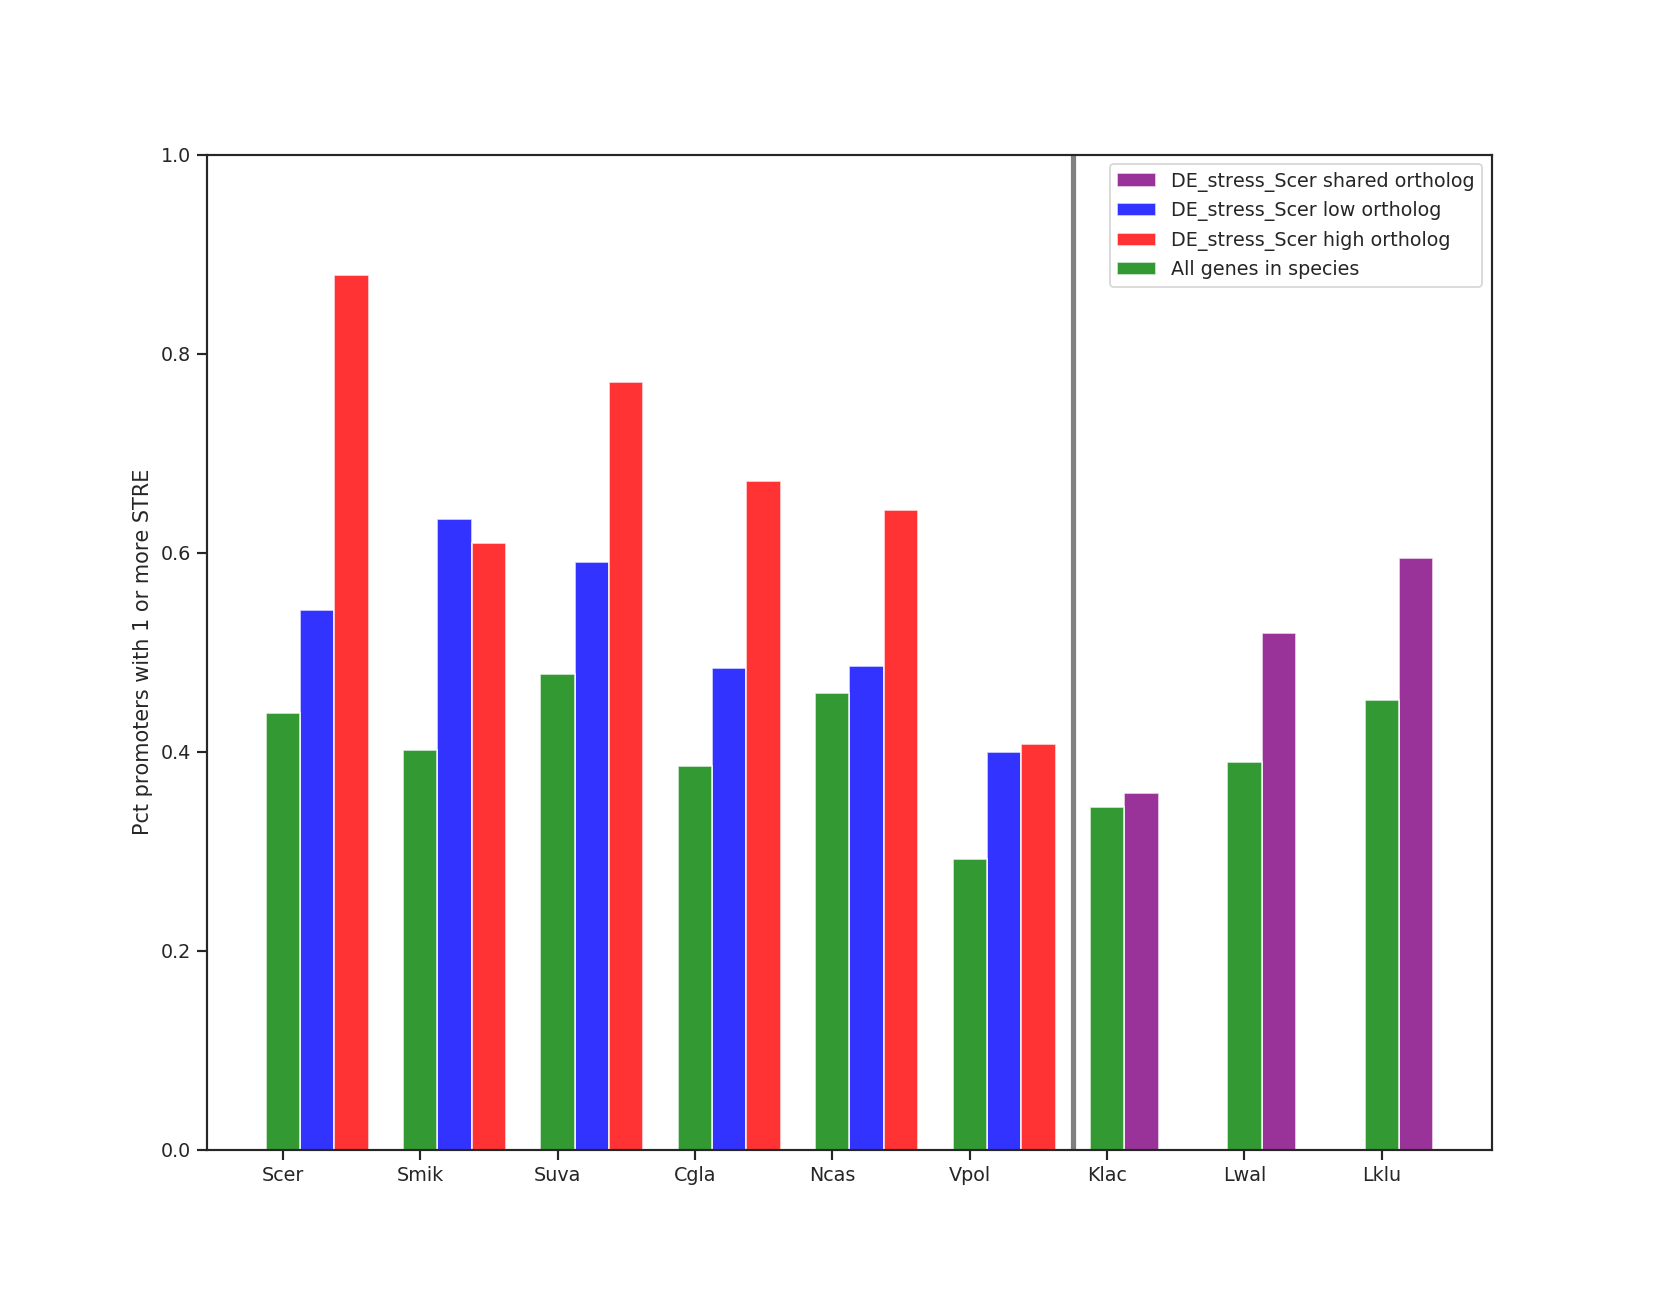

In [257]:
#Plot percentage of STREs in low and high as you go away from S.Cer

motif_name = 'STRE'

fig_pct, ax_pct = plt.subplots()
bw = 0.25
opacity = 0.8

spec_sets = {'Post WGH low' : spec_order_post_WGH, 
             'Post WGH high' : spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

colors = {'all':'green', 'low': 'blue', 'high':'red', 'Pre WGH': 'purple'}
legend_labels = {'all':'All genes in species', 'low': 'DE_stress_' + seed_spec + ' low ortholog', 
                 'high':'DE_stress_' + seed_spec + ' high ortholog', 'Pre WGH': 'DE_stress_' + seed_spec + ' shared ortholog'}
index = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
data = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
label_order = []
jj = 0

#Post WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Post WGH high']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['low'].append(jj+bw)
    index['high'].append(jj+bw*2)
    data['all'].append(motif_calcs['Post WGH high'][spec]['all'][motif_name]['pct'])
    data['low'].append(motif_calcs['Post WGH low'][spec]['goi'][motif_name]['pct'])
    data['high'].append(motif_calcs['Post WGH high'][spec]['goi'][motif_name]['pct'])    
    jj = jj+1

#pre WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Pre WGH']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['Pre WGH'].append(jj+bw)
    data['all'].append(motif_calcs['Pre WGH'][spec]['all'][motif_name]['pct'])
    data['Pre WGH'].append(motif_calcs['Pre WGH'][spec]['goi'][motif_name]['pct'])
    jj = jj+1

    
for subset_name, subset_data in data.items(): 
    
    pct_plot = ax_pct.bar(index[subset_name],subset_data, bw,
                 alpha=opacity,
                 color=colors[subset_name],
                 label=legend_labels[subset_name]) 
                 #bottom = bottom)

ax_pct.vlines([len(index['low'])-0.25], ymin = 0, ymax = 1.0, colors = 'gray',linewidth=3)
ax_pct.set_xticklabels(label_order)
ax_pct.set_xticks(index['all'])
ax_pct.set_ylim(0,1.0)
ax_pct.set_ylabel('Pct promoters with 1 or more STRE')
ax_pct.legend()

## STRE enrichment with DE Stress genes - V.Pol

In [261]:
#Load GOI ohnolog data

seed_spec = 'Vpol'

fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_' + seed_spec + '_PKAest_20190123.pkl')
with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

L_prom = 700
output_format = 'full'
motif_dict = {'STRE': 'CCCCT', 'TATA': 'TATA[AT]A[AT][AG]', 'PDS': 'AGGGAT'} 
sequence_context = 2   

spec_order_post_WGH = ['Vpol', 'Ncas', 'Cgla','Suva','Smik', 'Scer']  
spec_order_pre_WGH = ['Klac','Lwal','Lklu']  #might be able to get Calb promoters fairly easily

    
#Add SC_common_name_high, low and high_low columns to an ohnologs_file
ohnologs_goi = io_library.SC_common_name_columns_ohnologs(ohnologs_goi, seed_spec)
ohnologs_goi.reset_index(inplace=True)
ohnologs_goi.set_index('SC_common_name_high_low', inplace=True)

#Load expression_data_df_sorted in order to get correct order of genes
fname_exp_data_sorted = os.path.normpath(data_processing_dir + 'regev_data/20190130_expression_data_DE_stress_' + seed_spec +'_sorted.csv')
expression_data_df_sorted = pd.read_csv(fname_exp_data_sorted,index_col=0)

#Throw out genes that aren't in my ohnolog set.  
new_index = []
for high_low in expression_data_df_sorted.index: 
    if high_low in set(ohnologs_goi.index):
        new_index.append(high_low)
    else:
        print(high_low + ' not in ohnologs set')

#sort genes by new index: 
ohnologs_goi_rowsort = ohnologs_goi.loc[new_index,:]

ohnologs_goi = ohnologs_goi_rowsort
    
ohnologs_goi, motif_calcs = io_library.motif_scan_YGOB_specs(ohnologs_goi, seed_spec, spec_order_pre_WGH, spec_order_post_WGH, motif_dict, L_prom=L_prom,output_format=output_format, sequence_context=sequence_context )


Pre WGH
Klac
Klac_YGOB_STM1 not present in promoter dict for Klac
Lwal
Lklu
Post WGH high
Vpol
Kpol_387.1 not present in promoter dict for Vpol
Kpol_1037.61 not present in promoter dict for Vpol
Ncas
Cgla
Suva
Smik
Scer
Post WGH low
Vpol
Kpol_1002.123 not present in promoter dict for Vpol
Ncas
Cgla
Suva
Smik
Scer


<IPython.core.display.Javascript object>


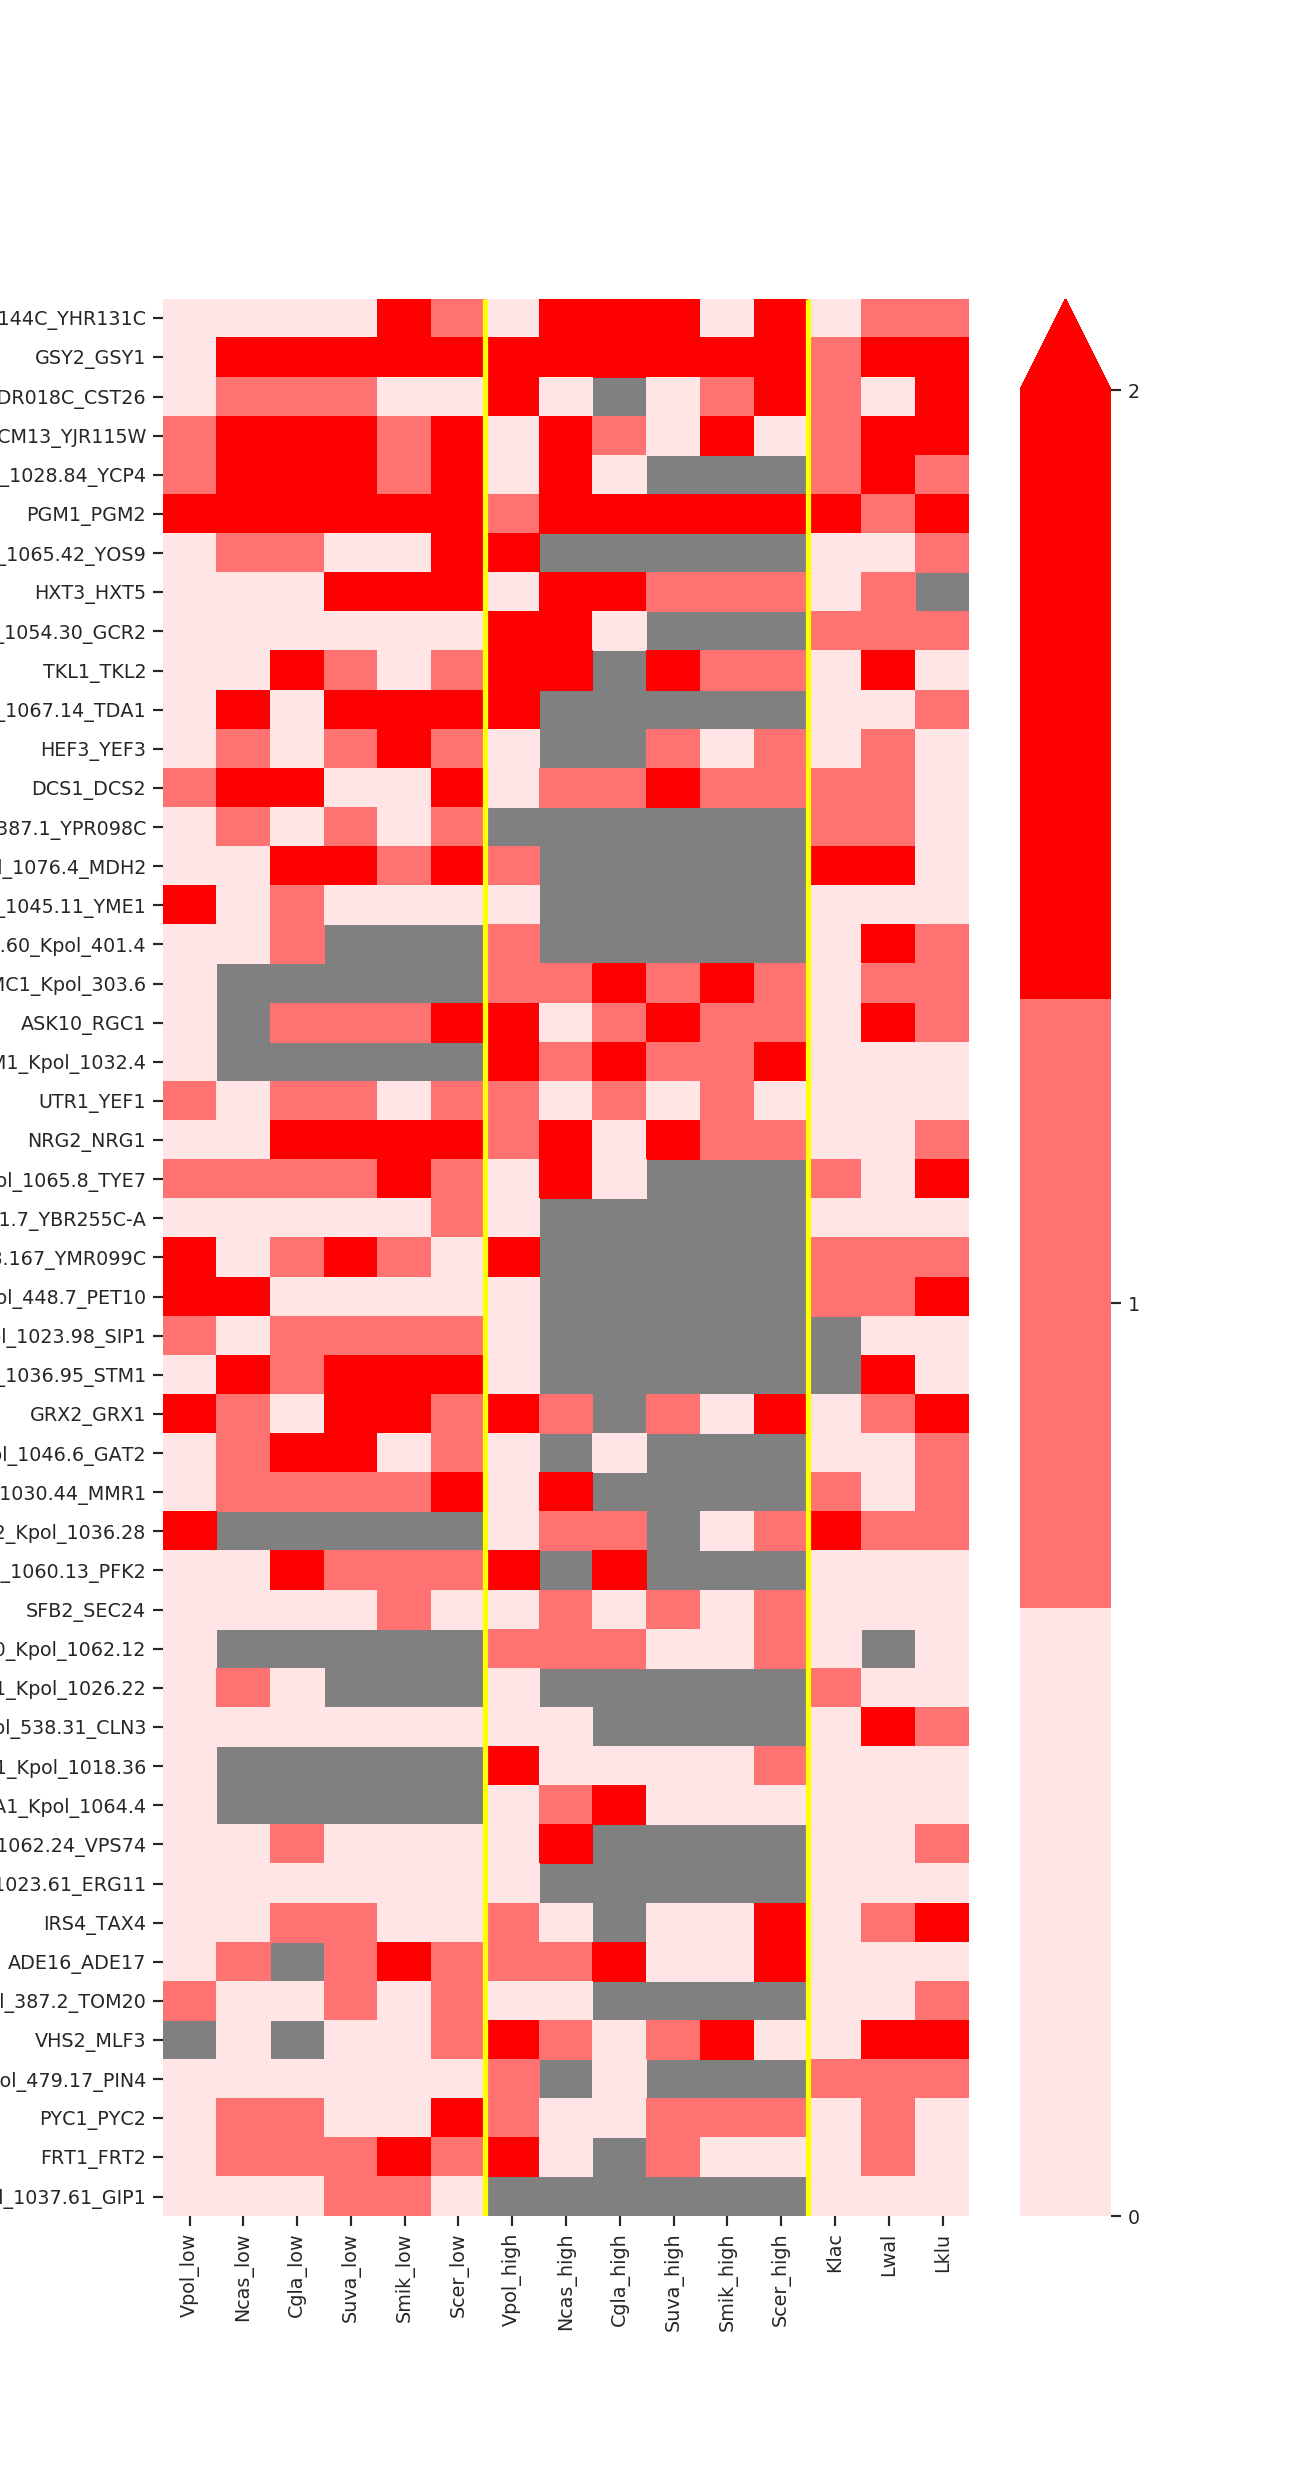

In [263]:
# Plot heatmap of all STREs in same order 
# heatmap after filtering and sorting

motif_name = 'STRE'

spec_sets = {'Post WGH low' : spec_order_post_WGH, 
             'Post WGH high' : spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}


columns_to_show = []
label_order = []
for spec_set_name in ['Post WGH low', 'Post WGH high', 'Pre WGH']: 
    spec_set = spec_sets[spec_set_name]
    level = levels[spec_set_name]
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'
        
    for spec in spec_set: 
        
        columns_to_show.append(spec + '_' + motif_name + '_count' + level_sep + level)
        label_order.append(spec + level_sep + level)
        
        
#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
  
big_lines = []
for jj,label in enumerate(label_order):
    if label in {'Scer_low', 'Scer_high'}:
        big_lines.append(jj+1)

        
        
ohnologs_goi_counts = ohnologs_goi.loc[:, columns_to_show]

fig_STRE, ax_STRE = plt.subplots(figsize=(5,20))

#cmap = cm.get_cmap('PiYG', 11) 
sns.heatmap(ohnologs_goi_counts, vmax = 2, ax=ax_STRE, cmap=sns.light_palette("red",3), cbar_kws={'ticks':[0,1,2], 'extend': 'max'}) #, 'yticklabels':['0', '1', '>1']})

ax_STRE.set_facecolor("grey")
ax_STRE.set_xticklabels(label_order)
ax_STRE.vlines(big_lines, ymin = 0, ymax = len(ohnologs_goi_counts), colors = 'yellow',linewidth=3)

fig_STRE.savefig(os.path.normpath('/home/heineike/scratch/' + motif_name + '_evol_DEstress' + seed_spec + '_20190130.svg'),bbox_inches='tight')


<IPython.core.display.Javascript object>


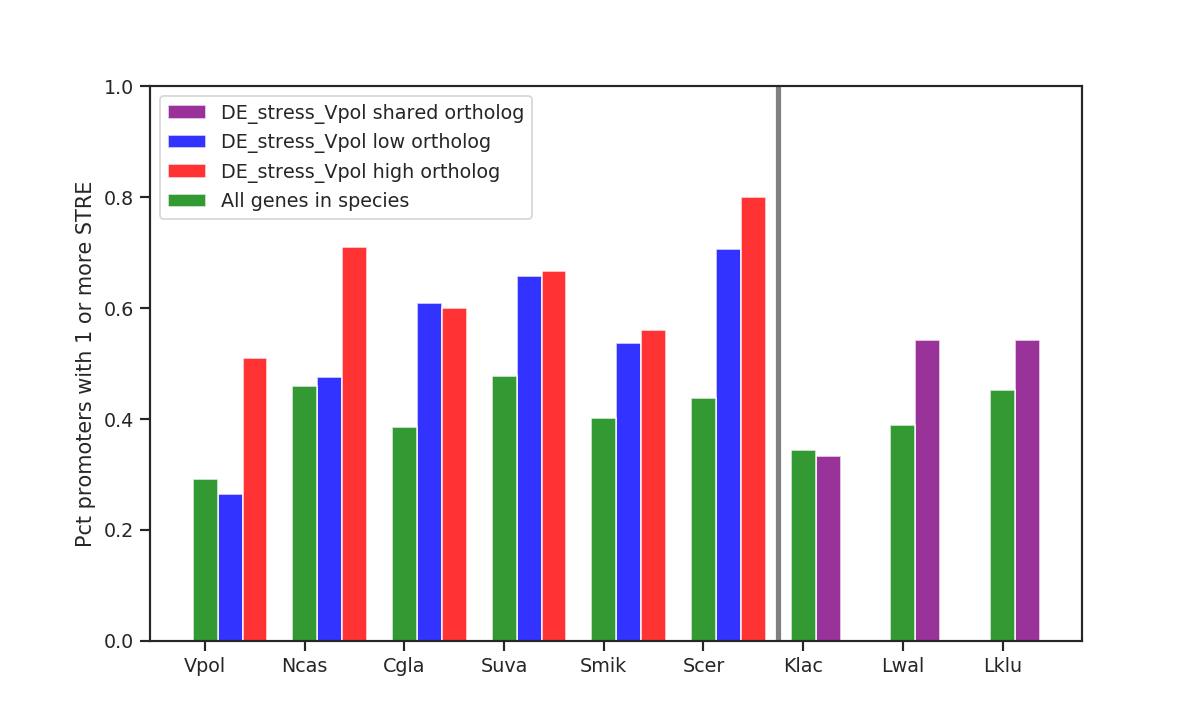

In [264]:
#Plot percentage of STREs in low and high as you go away from S.Cer

motif_name = 'STRE'

fig_pct, ax_pct = plt.subplots()
bw = 0.25
opacity = 0.8

spec_sets = {'Post WGH low' : spec_order_post_WGH, 
             'Post WGH high' : spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

colors = {'all':'green', 'low': 'blue', 'high':'red', 'Pre WGH': 'purple'}
legend_labels = {'all':'All genes in species', 'low': 'DE_stress_' + seed_spec + ' low ortholog', 
                 'high':'DE_stress_' + seed_spec + ' high ortholog', 'Pre WGH': 'DE_stress_' + seed_spec + ' shared ortholog'}
index = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
data = {'all':[], 'low':[],'high':[], 'Pre WGH':[]}
label_order = []
jj = 0

#Post WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Post WGH high']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['low'].append(jj+bw)
    index['high'].append(jj+bw*2)
    data['all'].append(motif_calcs['Post WGH high'][spec]['all'][motif_name]['pct'])
    data['low'].append(motif_calcs['Post WGH low'][spec]['goi'][motif_name]['pct'])
    data['high'].append(motif_calcs['Post WGH high'][spec]['goi'][motif_name]['pct'])    
    jj = jj+1

#pre WGH Species
#assumes the same species sets are in both
for spec in spec_sets['Pre WGH']: 
    label_order.append(spec)        
    index['all'].append(jj)
    index['Pre WGH'].append(jj+bw)
    data['all'].append(motif_calcs['Pre WGH'][spec]['all'][motif_name]['pct'])
    data['Pre WGH'].append(motif_calcs['Pre WGH'][spec]['goi'][motif_name]['pct'])
    jj = jj+1

    
for subset_name, subset_data in data.items(): 
    
    pct_plot = ax_pct.bar(index[subset_name],subset_data, bw,
                 alpha=opacity,
                 color=colors[subset_name],
                 label=legend_labels[subset_name]) 
                 #bottom = bottom)

ax_pct.vlines([len(index['low'])-0.25], ymin = 0, ymax = 1.0, colors = 'gray',linewidth=3)
ax_pct.set_xticklabels(label_order)
ax_pct.set_xticks(index['all'])
ax_pct.set_ylim(0,1.0)
ax_pct.set_ylabel('Pct promoters with 1 or more STRE')
ax_pct.legend()

## Attempt to get all promoters from y1000plus.  
Stopped because there is no syntenic mapping of all genomes as in YGOB, and no current mapping of known genes to genes found in y1000 plus. 

In [3]:
#extract species numbers for the Saccharomyces clade
y1000plus_dir = "/home/heineike/genomes/y1000plus/"
y1000_species_fname = y1000plus_dir + "343taxa_speicies-name_clade-name_color-code.txt"
y1000_species = pd.read_table(y1000_species_fname, index_col=0)

In [6]:
list(y1000_species['original_genome_id'])

['saprochaete_clavata',
 'yHMPu5000034974_deakozyma_indianensis_160519',
 'clavispora_lusitaniae',
 'yHMPu5000034999_cephaloascus_fragrans_160519',
 'yHMPu5000034998_cephaloascus_albidus_160519',
 'babjeviella_inositovora',
 'candida_dubliniensis',
 'candida_albicans',
 'candida_parapsilosis',
 'candida_homilentoma',
 'candida_tropicalis',
 'candida_orthopsilosis',
 'candida_carpophila',
 'candida_tanzawaensis',
 'candida_tenuis',
 'yHMPu5000034632_candida_athensensis_160519',
 'yHMPu5000035679_candida_rhagii_160613',
 'yHMPu5000035681_candida_gotoi_160519',
 'yHMPu5000034643_candida_schatavii_160519',
 'yHMPu5000035031_candida_kruisii_160519',
 'yHMPu5000035302_candida_fragi_160928',
 'debaryomyces_hansenii',
 'yHMPu5000041713_debaryomyces_maramus_160928',
 'yHMPu5000041693_debaryomyces_nepalensis_160928',
 'yHMPu5000041829_debaryomyces_fabryi_160928',
 'hyphopichia_burtonii',
 'yHMPu5000035318_hyphopichia_heimii_160928',
 'yHMPu5000035667_kurtzmaniella_cleridarum_160928',
 'lodderomy

In [26]:
#Build promoter fasta for all promoters in a given species

y1000plus_dir = "/home/heineike/genomes/y1000plus/"
L_prom = 700
genome_name = 'naumovozyma_castellii'

promoter_dir = data_processing_dir + os.path.normpath('promoter_phylogeny/promoter_sets/' + genome_name)
#os.mkdir(promoter_dir)
promoter_fname = os.path.normpath(promoter_dir + '/all_promoters_' + str(L_prom) + '.fasta')

with open(promoter_fname,'w') as f: 

    #if S.Cer skip finding promoter, 
    if genome_name != 'saccharomyces_cerevisiae':    
        #load gene_id map based on the species
        gene_lookup_spec_fname = y1000plus_dir + "id_lookups/" + genome_name + '.csv'
        gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

        # Load GTF for given sequence: 
        gtf_dir = "/home/heineike/genomes/y1000plus/0_332yeast_genomes/332_genome_annotations/gtf/"
        db_fname = gtf_dir + 'gffutils_dbs/' + genome_name + '.db'

        gtf_db = gffutils.FeatureDB(db_fname)

        #Extract sequences from genome
        genome_dir = "/home/heineike/genomes/y1000plus/0_332yeast_genomes/332_genome_assemblies/"

        genome_fname = genome_dir + genome_name + '.fas'

        seq_records = SeqIO.parse(genome_fname, "fasta")

        #For each gene, extract all related features, and then output chromosome and coordinates for the promoter
        short_promoters = {}
        for row in gene_lookup_spec.iterrows():
            y1000_id = row[0]
            gene_full = row[1].gene_full
            gene_id = row[1].gene_id   

            cursor = gtf_db.execute('select * from features where attributes like "%' + gene_full + '%"')
            all_features = cursor.fetchall()
            if len(all_features) == 0:
                print('No features found ' + gene_full + ' ' +genome_name)

            strand = all_features[0]['strand']
            chrom = all_features[0]['seqid']

            starts = []
            ends = []
            for feature in all_features: 
                starts.append(feature['start'])
                ends.append(feature['end'])

            #Adjust coordinates to get L_prom "promoter" sequences
            if strand == '-': 
                prom_end = max(ends) + 1
                prom_start = prom_end + L_prom   #should do min of this and the total length of the scaffold, 
            elif strand == '+': 
                prom_end = min(starts) - 1
                prom_start = max(0,prom_end - L_prom)

            #extract sequences from genome
            #This seems super inefficient - should group by chromosome first if possible. 
            for seq_record in seq_records:
                if seq_record.id == chrom:
                    scaffold = seq_record

            #if strand is negative, check to see if promoter coordinates are at the end of the scaffold

            L_scaffold = len(scaffold)

            if strand == '-': 
                if prom_start > L_scaffold: 
                    print('promoter region extends past the scaffold, genome_name = ' + genome_name + ' Gene = ' + gene_id + ', L_prom = ' + str(L_prom))
                    prom_start = L_scaffold
                if prom_end > L_scaffold: 
                    print('scaffold ends at the end of the gene, genome_name = ' + genome_name + ' Gene = ' + gene_id)
                    prom_end = L_scaffold

                promoter = scaffold.seq[prom_end:prom_start].reverse_complement()
            elif strand == '+': 
                promoter = scaffold.seq[prom_start:prom_end]
            
            if abs(prom_end-prom_start)<L_prom:
                short_promoters[y1000_id] = abs(prom_end-prom_start)
                
            #do not add promoter if it has L=0 
            if abs(prom_end-prom_start)>0: 
                f.write('>species=' + genome_name + ' y1000_id=' + y1000_id + ' gene_id=' + gene_id + ' gene_full=' + gene_full +
                      ' scaffold=' + chrom + " strand=" + strand + " start=" + str(prom_start) + ' end=' + str(prom_end) +  ' L=' + str(abs(prom_end-prom_start)) + '\n')
                f.write(str(promoter.upper()) + '\n')  #I wonder why some of the bases were in lower case

short_promoters_fname = os.path.normpath(promoter_dir + '/short_promoters.fasta')
with open(short_promoters_fname,'w') as f: 
    for y1000_id, L_short_prom in short_promoters.items(): 
        f.write(y1000_id + '\t' + str(L_short_prom) + '\n')     

            

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1012, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1012
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1025, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1025
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1030, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1030
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_105, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_105
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1052, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1052
promote

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1695, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1695
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1702, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1702
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1708, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1708
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1728, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1728
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_1741, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_1741
promo

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2364, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2364
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2376, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2376
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2385, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2385
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2389, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2389
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2415, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2415
promo

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2977, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2977
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2983, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2983
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_2986, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_2986
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3028, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3028
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3032, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3032
promo

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3736, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3736
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3740, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3740
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3755, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3755
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3815, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3815
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_3826, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_3826
promo

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4471, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4471
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4476, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4476
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4513, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4513
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4514, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4514
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4526, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4526
promo

promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_4971, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_4971
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_500, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_500
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_502, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_502
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_5029, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_5029
promoter region extends past the scaffold, genome_name = naumovozyma_castellii Gene = Seq_5052, L_prom = 700
scaffold ends at the end of the gene, genome_name = naumovozyma_castellii Gene = Seq_5052
promoter 

ValueError: too many values to unpack (expected 2)

In [ ]:
#given genes of interest, identify paralogs from other species
#start with YGOB and only for species in Regev set

YGOB: 
Ncas, Suva, Sbay, Smik, ,['Cgla', 'Scer' ]

['Klac','Lklu', Lwal

Regev: 
 post: Spar
 Dhan, Calb, Ylip,  Sjap, Spom 
 
 
#expand to hittinger lab species. 

#For a given set of genes in a species calculate enrichment